In [1]:
import numpy as np
import pandas as pd

# O que fazer?

* Contar os casos onde a calibragem acertou e a proba errou.
* Contar o raking os casos onde a calibragem errou e a proba errou.

In [27]:
def get_miss_convertions(y_true: np.ndarray,
                         main_preds: np.ndarray,
                         second_preds: np.ndarray) -> np.int64:

    A = y_true == main_preds
    B = y_true != second_preds
    return np.sum(np.logical_and(A, B))

def get_ranking(label:np.ndarray, 
                A:np.ndarray, 
                B:np.ndarray) -> tuple:
    
    # Getting the position of the right class for both strategies.
    ranking_a = np.where((1 - A).argsort() == label)[0][0]
    ranking_b = np.where((1 - B).argsort() == label)[0][0]

    gap = ranking_b - ranking_a
    rflip = 1 if gap > 0 else 0

    return (rflip, gap)


def get_ranking_change(y_true:np.ndarray, 
                       main_proba:np.ndarray, 
                       second_proba:np.ndarray) -> tuple:
    
    main_pred = main_proba.argmax(axis=1)
    second_pred = second_proba.argmax(axis=1)

    """
    # Main classifier missed.
    A = y_true != main_pred
    # Second classifier missed.
    B = y_true != second_pred
    # Both missed equal.
    index = np.logical_and(A, B)
    """
    index = np.arange(y_true.shape[0])

    # For each document on both missed.
    gaps = []
    rflips, rdist = 0, 0, 
    for label, A_probas, B_probas in zip(y_true[index], main_proba[index], second_proba[index]):
        rflip, gap = get_ranking(label, A_probas, B_probas)
        rflips += rflip
        rdist += gap
        if gap != 0:
            gaps.append(gap)
        
    return (rflips, rdist, gaps)

In [28]:
STACKING_DIR = "/home/welton/data/stacking/stacking_output"
LABELS_DIR = "/home/welton/data/datasets/labels/split_10"

DATASETS = ["20ng", "acm"]
ranking_dict = {}


# The first strategie is the main strategy.
strategies = ["calibrated", "normal_probas"]
main_strat, second_strat = strategies
for dataset in DATASETS:
    ranking_dict[dataset] = {}
    ranking_dict[dataset][main_strat] = []
    ranking_dict[dataset][second_strat] = []
    for fold in np.arange(10):
        
        
        main_dir = f"{STACKING_DIR}/{dataset}/10_folds/logistic_regression/{main_strat}/fold_{fold}"
        main_probas = np.load(f"{main_dir}/probas.npz")["X_test"]
        main_pred = main_probas.argmax(axis=1)
        #main_pred = np.load(f"{main_dir}/y_pred.npy")

        second_dir = f"{STACKING_DIR}/{dataset}/10_folds/logistic_regression/{second_strat}/fold_{fold}"
        second_probas = np.load(f"{second_dir}/probas.npz")["X_test"]
        second_pred = second_probas.argmax(axis=1)
        #second_pred = np.load(f"{second_dir}/y_pred.npy")

        y_true = np.load(f"{LABELS_DIR}/{dataset}/{fold}/test.npy")

        main_conv = get_miss_convertions(y_true, main_pred, second_pred)
        rflips, rgap, gaps = get_ranking_change(y_true, main_probas, second_probas)
        ranking_dict[dataset][main_strat].append([fold, main_conv, rflips, rgap, gaps])

        second_conv = get_miss_convertions(y_true, second_pred, main_pred)
        rflips, rgap, gaps = get_ranking_change(y_true, second_probas, main_probas)
        ranking_dict[dataset][second_strat].append([fold, second_conv, rflips, rgap, gaps])

        

In [49]:
ranking_dict["acm"]["calibrated"][0]

[0,
 16,
 74,
 30,
 [1,
  1,
  1,
  -1,
  3,
  1,
  1,
  1,
  1,
  4,
  3,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  2,
  -1,
  1,
  1,
  -1,
  2,
  1,
  -1,
  1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  2,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  -2,
  1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  -1,
  3,
  1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  1,
  1,
  1,
  -1,
  -3,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -2,
  -2,
  -4,
  -2,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  -1,
  -1,
  1,
  2,
  -1,
  -1,
  1,
  -1,
  -2,
  -1,
  -1,
  2,
  -2,
  2,
  3]]

In [62]:
title_labels = {
    "calibrated": "Calibrated",
    "normal_probas": "Not Calibrated"
}

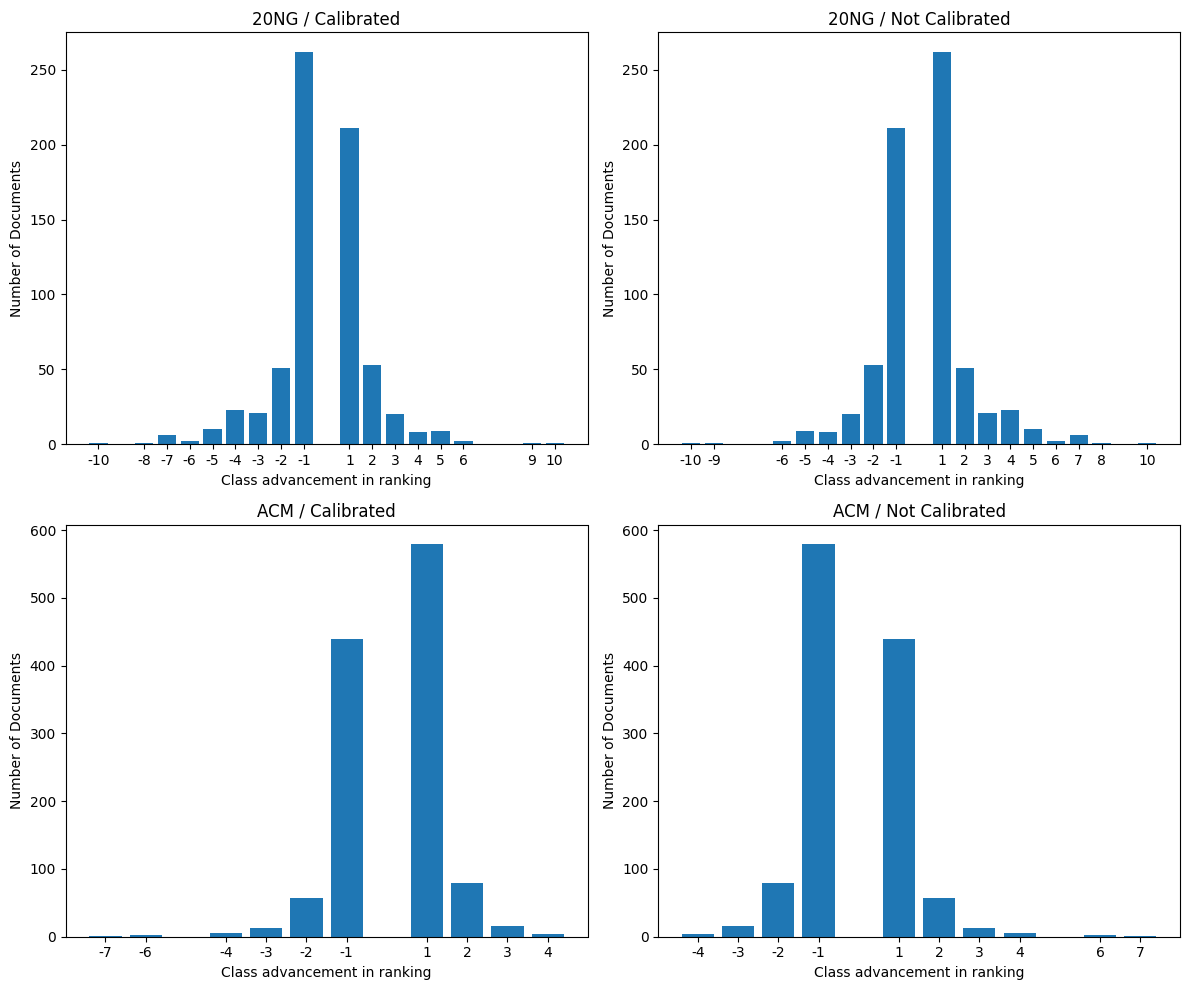

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt_idx = 1
for dataset in ranking_dict:
    for strategy in ranking_dict[dataset]:
        gaps = np.hstack([ fold[4] for fold in ranking_dict[dataset][strategy] ]).reshape(-1)
        gap_counts = pd.Series(gaps).value_counts()
        x = sorted(list(gap_counts.keys()))
        y = [ gap_counts[key] for key in x ]
        plt.subplot(2, 2, plt_idx)
        plt.bar(x, y)
        _ = plt.xticks(ticks=x, labels=x)
        plt.title(f"{dataset.upper()} / {title_labels[strategy]}")
        plt.xlabel("Class advancement in ranking")
        plt.ylabel("Number of Documents")
        plt_idx += 1
plt.tight_layout()
        

In [59]:
x, y

([-4, -3, -2, -1, 1, 2, 3, 4, 6, 7], [4, 16, 80, 579, 439, 57, 13, 6, 2, 1])

In [31]:
np.sum(np.array(ranking_dict["20ng"]["calibrated"])[:, [1,2,3]], axis=0)

/tmp/ipykernel_475683/482307758.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.sum(np.array(ranking_dict["20ng"]["calibrated"])[:, [1,2,3]], axis=0)


array([97, 305, -156], dtype=object)

In [32]:
(np.sum(np.array(ranking_dict["20ng"]["calibrated"])[:, [1,2,3]], axis=0) / 18846) * 100

/tmp/ipykernel_475683/1729898421.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (np.sum(np.array(ranking_dict["20ng"]["calibrated"])[:, [1,2,3]], axis=0) / 18846) * 100


array([0.5146980791679933, 1.6183805582086386, -0.8277618592804838],
      dtype=object)

In [33]:
np.sum(np.array(ranking_dict["20ng"]["normal_probas"])[:, [1,2,3]], axis=0)

/tmp/ipykernel_475683/38433033.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.sum(np.array(ranking_dict["20ng"]["normal_probas"])[:, [1,2,3]], axis=0)


array([126, 377, 156], dtype=object)

In [34]:
(np.sum(np.array(ranking_dict["20ng"]["normal_probas"])[:, [1,2,3]], axis=0) / 18846) * 100

/tmp/ipykernel_475683/50092818.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (np.sum(np.array(ranking_dict["20ng"]["normal_probas"])[:, [1,2,3]], axis=0) / 18846) * 100


array([0.6685768863419294, 2.0004244932611694, 0.8277618592804838],
      dtype=object)

In [35]:
np.sum(np.array(ranking_dict["acm"]["calibrated"])[:, [1,2,3]], axis=0)

/tmp/ipykernel_475683/2034122316.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.sum(np.array(ranking_dict["acm"]["calibrated"])[:, [1,2,3]], axis=0)


array([182, 679, 168], dtype=object)

In [36]:
(np.sum(np.array(ranking_dict["acm"]["calibrated"])[:, [1,2,3]], axis=0) / 24897) * 100

/tmp/ipykernel_475683/204622567.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (np.sum(np.array(ranking_dict["acm"]["calibrated"])[:, [1,2,3]], axis=0) / 24897) * 100


array([0.731011768486163, 2.727236213198377, 0.6747800939872274],
      dtype=object)

In [37]:
np.sum(np.array(ranking_dict["acm"]["normal_probas"])[:, [1,2,3]], axis=0)

/tmp/ipykernel_475683/3035203466.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.sum(np.array(ranking_dict["acm"]["normal_probas"])[:, [1,2,3]], axis=0)


array([162, 518, -168], dtype=object)

In [38]:
(np.sum(np.array(ranking_dict["acm"]["normal_probas"])[:, [1,2,3]], axis=0) / 24897) * 100

/tmp/ipykernel_475683/4087422606.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (np.sum(np.array(ranking_dict["acm"]["normal_probas"])[:, [1,2,3]], axis=0) / 24897) * 100


array([0.650680804916255, 2.0805719564606178, -0.6747800939872274],
      dtype=object)